<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import time
sns.set(style='darkgrid', font_scale=1.4)
RANDOM_STATE = 42

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('datasets/taxi.csv',index_col=[0], parse_dates=[0])    

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.index.is_monotonic

True

In [6]:
print(data.index.min(), data.index.max())

2018-03-01 00:00:00 2018-08-31 23:50:00


In [7]:
data = data.resample('1H').sum()

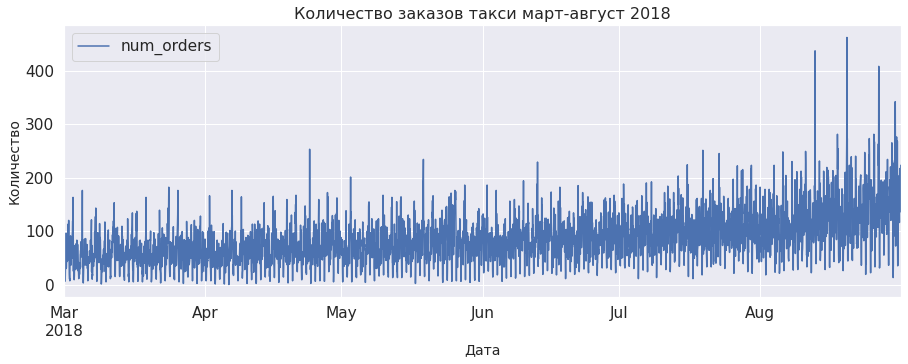

In [8]:
data.plot(figsize=(15,5))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Количество заказов такси март-август 2018', fontsize=16)
plt.legend();

Пропусков в данных нет. Данные монотоны, значит дубликатов в значениях дат не имеется. В целом замтно, что к концу периода минимальное количество заказов увеличилось, так же видно множество пиков в какие-то конкретные часы.

## Анализ

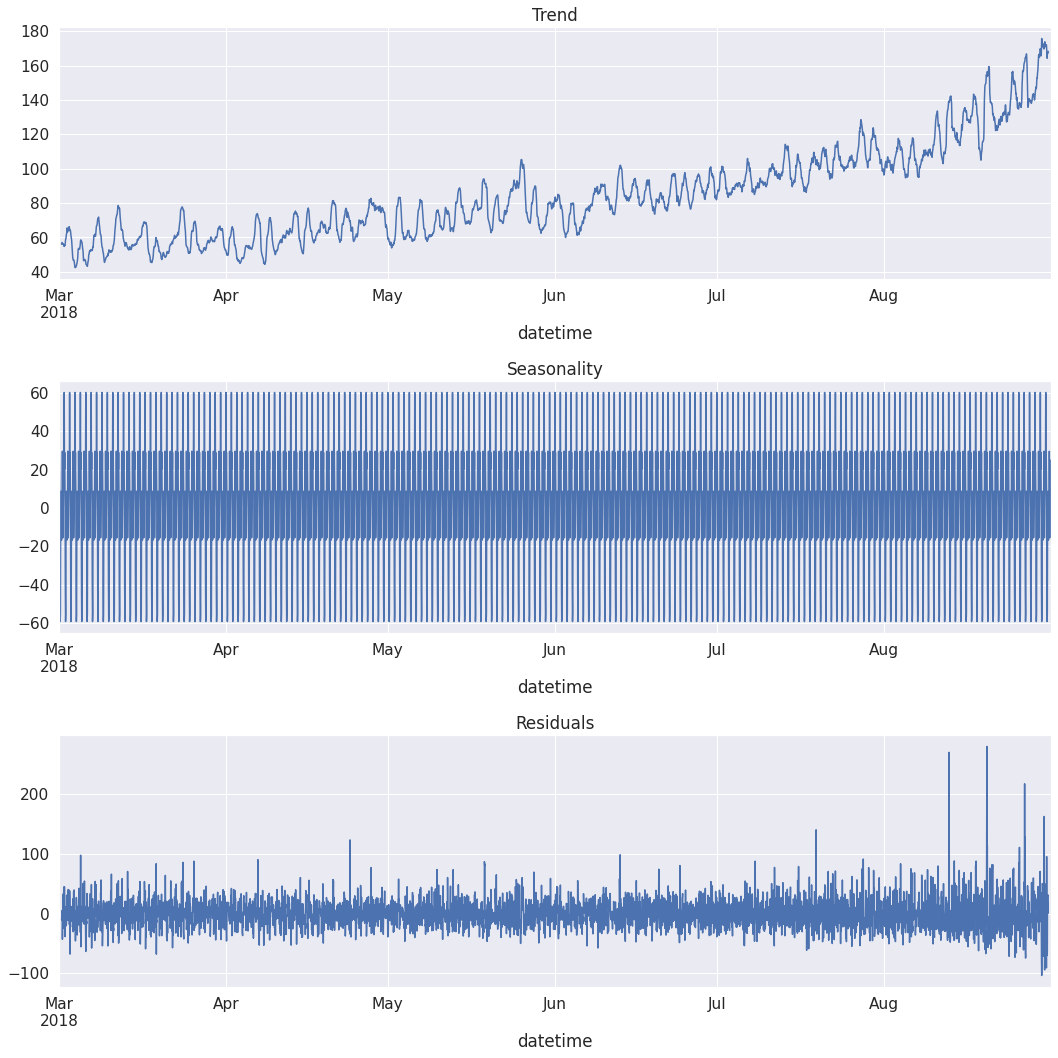

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Видим восходящий тренд к концу лета однако сезонность оценить нельзя. Рассмотрим более узкий временой период.

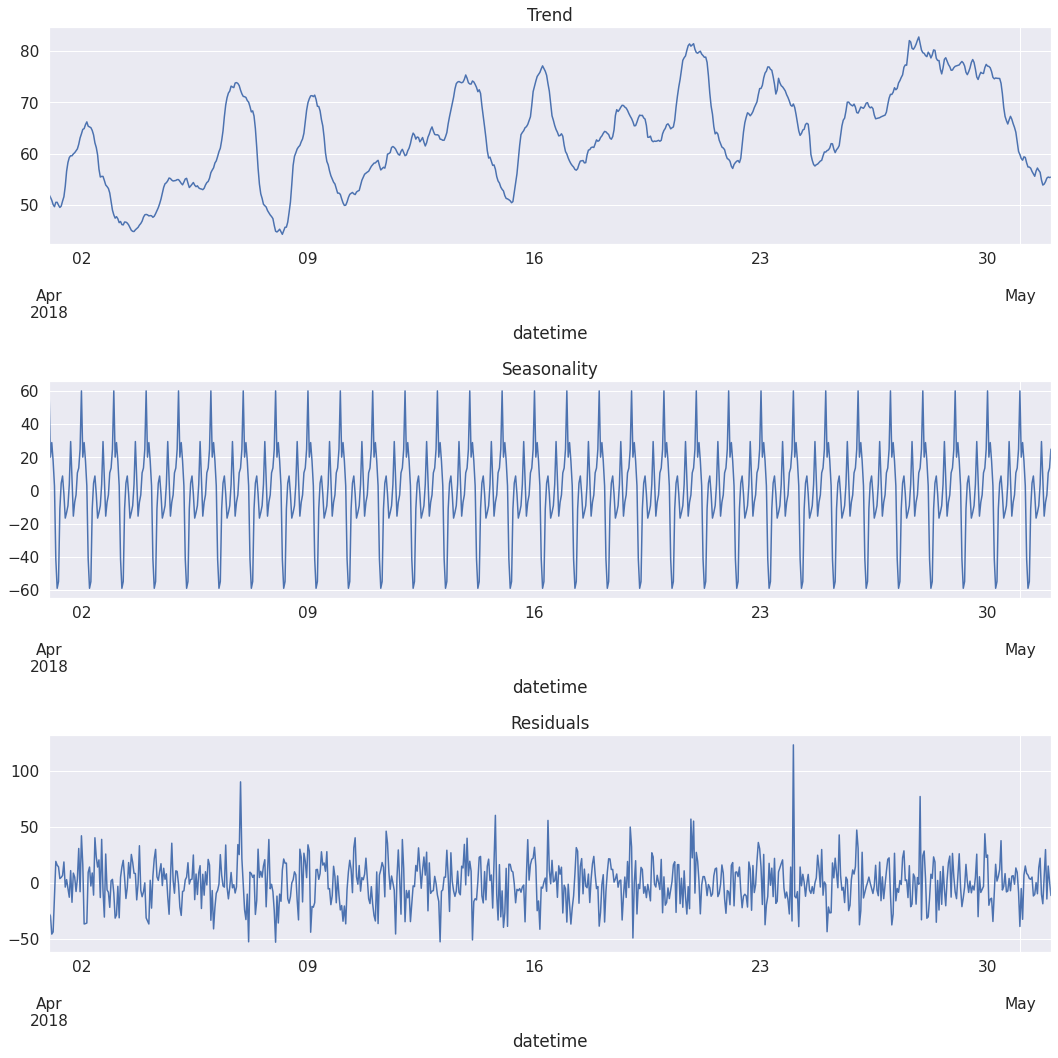

In [10]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend['2018-04-01':'2018-05-1'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-05-1'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-04-01':'2018-05-1'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Прослеживаются закономерности в сезонности.

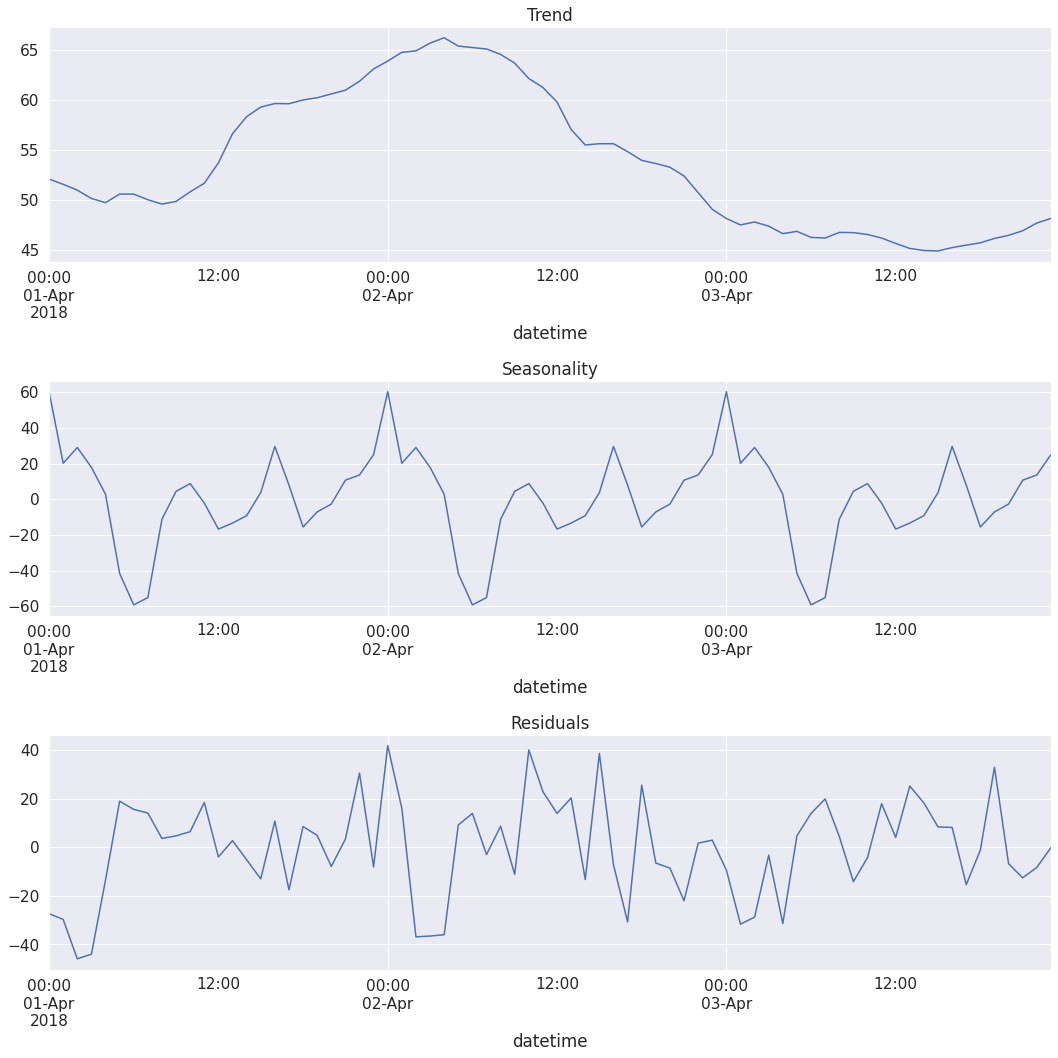

In [11]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend['2018-04-01':'2018-04-3'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-3'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-04-01':'2018-04-3'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Большинство заказов приходятся на 12 часов ночи, минимальное количество в районе 6 утра

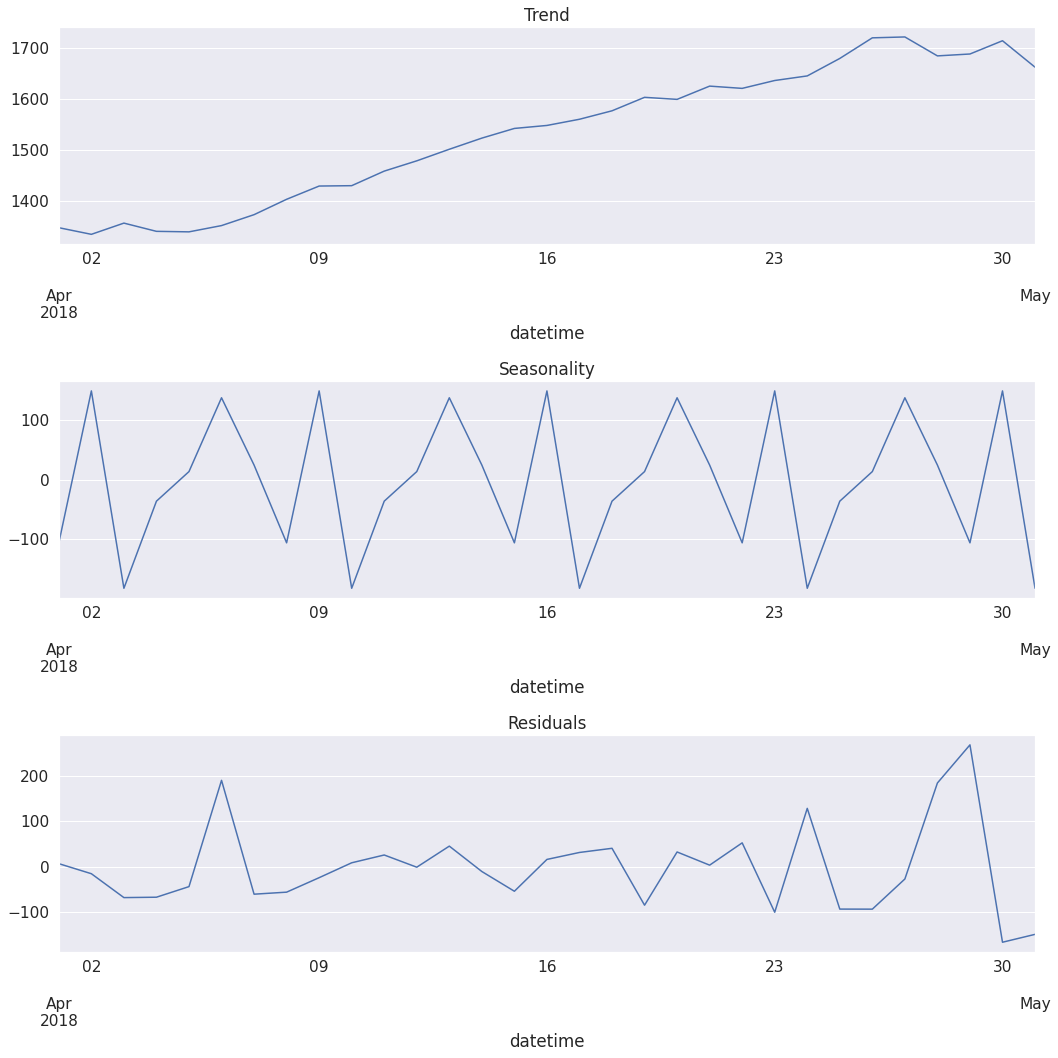

In [12]:
plt.figure(figsize=(15, 15))
data_day = data.resample('1D').sum()
decomposed_day = seasonal_decompose(data_day)
plt.subplot(311)
decomposed_day.trend['2018-04-01':'2018-05-1'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_day.seasonal['2018-04-01':'2018-05-1'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_day.resid['2018-04-01':'2018-05-1'].plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Сезонность внутри недели также присутсвует

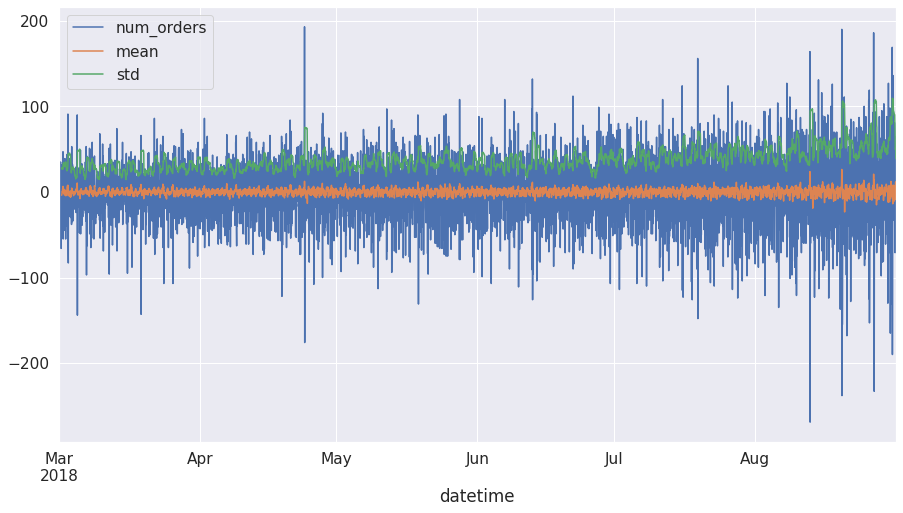

In [13]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(15).mean()
data_shift['std'] = data_shift['num_orders'].rolling(15).std()
data_shift.plot(figsize=(15, 8));

Такой ряд выглядит более стационарным, стандартное отклонение меньше подвережено колебаниям.

*Проведем тест Дики-Фуллера* 

H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H A : временной ряд является стационарным.

In [14]:
test = adfuller(data['num_orders'])
print ('adf:', test[0])
print('p-value:', test[1])
print ('Critical values:', test[4])
if test[0]> test[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf: -3.0689242890279558
p-value: 0.028940051402612906
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [16]:
make_features(data, 10, 10)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders',axis=1)
y_train = train.num_orders
X_test = test.drop('num_orders',axis=1)
y_test = test.num_orders

In [17]:
models = {
    "RandomForest" : RandomForestRegressor(random_state=RANDOM_STATE),
    "LGBM" : LGBMRegressor(random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=RANDOM_STATE)
}
Lasso_grid = {'alpha':[0.02, 0.024, 0.026, 0.03]}
Ridge_grid = {'alpha':[200, 230, 250, 270, 290, 300]}
El_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}

DT_grid = {'max_depth': [4, 6, 8, 10],
            'min_samples_leaf': [1, 3, 5, 8]}

RF_grid = {'n_estimators': [5, 10, 15],
        'max_depth': [4, 6, 8, 10]}

boost_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

grid = {
    "RandomForest" : RF_grid,
    "LGBM" : boost_grid,
    "DecisionTree" : DT_grid,
    'Ridge': Ridge_grid,
    'Lasso': Lasso_grid,
    'ElasticNet': El_grid
}
cv = TimeSeriesSplit(n_splits=3)

In [18]:
def pipeline(X_train, y_train):
    i=0
    reg_best_params=models.copy()
    valid_scores=pd.DataFrame({'Model':models.keys(), 'RMSE': np.zeros(len(models)), 'Training time': np.zeros(len(models))})
    for key, model in models.items():
        reg = RandomizedSearchCV(estimator=model, param_distributions=grid[key], n_jobs=-1,
                                 cv=cv, scoring='neg_root_mean_squared_error')
        start = time.time()

        reg.fit(X_train, y_train)
        valid_scores.iloc[i,1]=reg.best_score_

        reg_best_params[key]=reg.best_params_

        stop = time.time()
        valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

        print('Model:', key)
        print('Training time (mins):', valid_scores.iloc[i,2])
        print('')
        i+=1
    return valid_scores, reg_best_params 

In [ ]:
valid_scores, reg_best_params = pipeline(X_train, y_train)

In [20]:
valid_scores

,Model,RMSE,Training time
0,RandomForest,-28.364876,0.04
1,LGBM,-27.497842,0.53
2,DecisionTree,-30.076075,0.01
3,Ridge,-33.701692,0.02
4,Lasso,-33.701554,0.05
5,ElasticNet,-33.565575,0.08


Наилучшее качество на кросс-валидации у LGBM, возьмем эту модель для тестирования.

## Тестирование

In [21]:
final_model = LGBMRegressor(**reg_best_params["LGBM"], random_state=RANDOM_STATE)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 43.92073798773651


In [22]:
print('RMSE:',mean_squared_error(data['num_orders'][len(X_train):].iloc[1:],
                   data['num_orders'][len(X_train):].shift(1).iloc[1:], squared=False))

RMSE: 58.52022221405402


При использовании в качестве бэйзлайн модели подстановку предыдущего значения таргета размер выбрки котрой соответсвует тестовой, значение RMSE ниже, чем у LGBM.

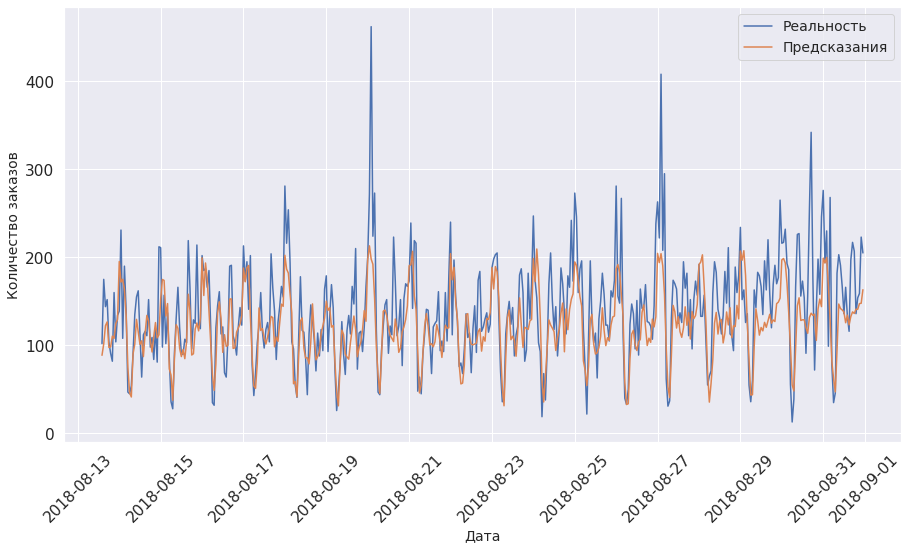

In [23]:
y_pred = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(15,8))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов',fontsize=14)
plt.plot(y_test, label='Реальность')
plt.plot(y_pred, label='Предсказания')
plt.legend(fontsize=14)
plt.xticks(rotation = 45) 
plt.show()

## Вывод

Для предсказания количества заказов были проанализированы данные с марта по август 2018 года. Выявлен пик закахов в 12 часов ночи, а также минимум в 6 утра. Тест Дики-Фуллера показал стационарность ряда. Для анализа были созданы признаки, такие как день, месяцб день недели и час заказа. Для тестирования выбрана модель LGBM. Качество данной модели превышает заданый бэйслайн,  а значит ее можно использовать для предсказния.